In [1]:
import nltk
import json

In [2]:
from tqdm import tqdm

In [3]:
file_d = []
reviews_sent = []
reviews_neg_sent = []
reviews_str = ""
reviews_pos_str = ""
reviews_neg_str = ""

In [4]:
file = '/Users/gkhanna/Downloads/reviews_Home_and_Kitchen_5.json'

Reading "count" of the file for faster experiments
count = 0 pulls in all data

In [5]:
# Reading count number of JSON lines from the file
count = 0
n = 0
with open(file, "r") as f:
    for line in tqdm(f):
        file_d.append(json.loads(line))
        n =  n + 1
        if count > 0 and n == count:
            break
    


551682it [00:07, 71345.42it/s]


In [6]:
# Checking the structures
print(len(file_d))
print(type(file_d))
print(file_d[0])
print(type(file_d[0]))

551682
<class 'list'>
{'reviewerID': 'APYOBQE6M18AA', 'asin': '0615391206', 'reviewerName': 'Martin Schwartz', 'helpful': [0, 0], 'reviewText': 'My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.', 'overall': 5.0, 'summary': 'Best Price', 'unixReviewTime': 1382140800, 'reviewTime': '10 19, 2013'}
<class 'dict'>


In [7]:
print(file_d[0]['reviewText'])

My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.


Read in reviews that correspond to the list of ASIN's (Amazon product ID's) selected. 
Choosing the ASIN that has ~ 1000 reviews from the EDA

In [8]:
pl = ['B00006JSUA']

In [9]:
# Getting the reviews out of the dictionary
# into a list and string
for r in tqdm(file_d):
    if r['asin'] in pl:
        reviews_sent.append(r['reviewText'])
        reviews_str = reviews_str + str(r['reviewText'])
        if ((r['overall'] == 1.0) or (r['overall'] == 2.0)):
            reviews_neg_str = reviews_neg_str + str(r['reviewText'])
        else:
            reviews_pos_str = reviews_pos_str + str(r['reviewText'])

100%|██████████| 551682/551682 [00:00<00:00, 1796354.55it/s]


In [10]:
print(type(reviews_sent))
print(len(reviews_sent))
print(reviews_sent[0])

<class 'list'>
1064
Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.


In [11]:
# print(reviews_sent)

In [12]:
print(len(reviews_str))
print(len(reviews_pos_str))
print(len(reviews_neg_str))

598363
572557
25806


In [13]:
print(reviews_str[:30])
print(reviews_pos_str[:30])
print(reviews_neg_str[:30])

Just say no to chemical treatm
Just say no to chemical treatm
I've always bought the regular


Separating out sentences into a list
PunktSentenceTokenizer is customized to separate sentences on a few extra words and characters as well.

In [14]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars
'''We customize the ReviewLangVars class to separate sentences based on some additional keywords'''


class ReviewLangVars(PunktLanguageVars):
    sent_end_chars = ('pros:', 'cons:', '[','][','.','?','!')
    
sent_tokenizer1 = PunktSentenceTokenizer(lang_vars = ReviewLangVars())
# sent_tokenizer1 = PunktSentenceTokenizer()
sent_fullreview = sent_tokenizer1.tokenize(reviews_str)
sent_neg_review = sent_tokenizer1.tokenize(reviews_neg_str)
sent_pos_review = sent_tokenizer1.tokenize(reviews_pos_str)

In [15]:
# This are the original sentences tokenized
print(sent_fullreview[0])
print(sent_fullreview[:5])
print(len(sent_fullreview))

Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!
['Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!', 'I use it ALL the time!!', "I re-season it a bit as well to keep it going strong!I've always bought the regular Lodge skillets and loved them.", 'Went with the pre-seasoned this time because I wanted this size.Wow, what a pain.', "I picked the best I could find from a stack on a big-box store shelf, so I know I didn't get a lemon (unless the whole batch was badly pre-seasoned!)."]
5704


In [16]:
# This are the negative sentences tokenized
print(sent_neg_review[0])
print(sent_neg_review[:5])
print(len(sent_neg_review))

I've always bought the regular Lodge skillets and loved them.
["I've always bought the regular Lodge skillets and loved them.", 'Went with the pre-seasoned this time because I wanted this size.Wow, what a pain.', "I picked the best I could find from a stack on a big-box store shelf, so I know I didn't get a lemon (unless the whole batch was badly pre-seasoned!).", 'The coating flaked off, got my hands black, and smelled really rusty.', 'No WAY I could cook with it that way!It has taken me about five rounds of boiling soapy water and then vinegar and water to get most of that nasty coating off of there with a steel scurbber.']
232


In [17]:
# This are the positive sentences tokenized
print(sent_pos_review[0])
print(sent_pos_review[:5])
print(len(sent_pos_review))

Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!
['Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!', 'I use it ALL the time!!', 'I re-season it a bit as well to keep it going strong!So far I am loving this skillet!', "It's priced well and you can tell it is good quality.", "I've used it to make a skillet cookie, asparagus, and saute shrimp (not all at the same time!)."]
5473


Extracting common Items using apriori
https://github.com/asaini/Apriori

In [18]:
import sys

from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser


def subsets(arr):
    """ Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
        """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)

        for item in itemSet:
                for transaction in transactionList:
                        if item.issubset(transaction):
                                freqSet[item] += 1
                                localSet[item] += 1

        for item, count in localSet.items():
                support = float(count)/len(transactionList)

                if support >= minSupport:
                        _itemSet.add(item)

        return _itemSet


def joinSet(itemSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))              # Generate 1-itemSets
    return itemSet, transactionList


def runApriori(data_iter, minSupport, minConfidence):
    """
    run the apriori algorithm. data_iter is a record iterator
    Return both:
     - items (tuple, support)
     - rules ((pretuple, posttuple), confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets,value=support)
    # which satisfy minSupport

    assocRules = dict()
    # Dictionary which stores Association Rules

    oneCSet = returnItemsWithMinSupport(itemSet,
                                        transactionList,
                                        minSupport,
                                        freqSet)

    currentLSet = oneCSet
    k = 2
    while(currentLSet != set([])):
        largeSet[k-1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(currentLSet,
                                                transactionList,
                                                minSupport,
                                                freqSet)
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
            """local function which Returns the support of an item"""
            return float(freqSet[item])/len(transactionList)

    toRetItems = []
    for key, value in tqdm(list(largeSet.items())):
        toRetItems.extend([(tuple(item), getSupport(item))
                           for item in value])

    toRetRules = []
    for key, value in tqdm(list(largeSet.items())[1:]):
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item)/getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)),
                                           confidence))
    return toRetItems, toRetRules


def printResults(items):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    for item, support in sorted(items, key=lambda item_support: item_support[1], reverse=True):
        print(str(item), support)

In [19]:
# Utility functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

lem = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
lem_word_mapping = {}

# Find leaves of a tree
def leaves(tree):
    """Finds leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() in ['P1','P2','P3','P4','P5','P6','P7','P8']):
        yield subtree.leaves()
    
def stem(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = word.replace("'","").replace('"','').replace('.','')
    word1 = stemmer.stem(word)
    return word1

# lowercase, stem and lemmatize
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word1 = stemmer.stem(word)
    word2 = lem.lemmatize(word1)
    if word != word2:
        lem_word_mapping[word2] = word
    return word2

def acceptableWord(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool((2 <= len(word) <= 40) and word.lower() not in stopwords)
    return accepted

# extract words after normalizing and checking if acceptable
def getTerms(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ stem(w) for w in tree if acceptableWord(w) ]
    return term
    
def getNorm(tree):
    """Parse leaves in chunk and return after checking acceptable conditions, normalizing and lemmatizing"""
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptableWord(w) ]
        yield term

Set of nouns for each sentence

In [20]:
# Set of nouns for the apriori algorithm

def isNoun(n):
    if n=='NN' or n=='NNS' or n=='NNP' or n=='NNPS':
        return True

revset=[]
for line in tqdm(sent_fullreview):
    # print(line)
    a = nltk.word_tokenize(line)
    # print(a)
    nouns = [word for (word, pos) in nltk.pos_tag(a) if isNoun(pos)] 
    # print(nouns)
    terms = getTerms(nouns)
    # print(terms)

    revset.append(terms)



100%|██████████| 5704/5704 [00:09<00:00, 611.89it/s]


In [21]:
print(revset[0])
print(revset[:10])

['treatment', 'stick', 'pan', 'friend', 'size', 'cast', 'iron', 'pan', 'children', 'chemic', 'part', 'pan', 'decadesthi', 'skillet']
[['treatment', 'stick', 'pan', 'friend', 'size', 'cast', 'iron', 'pan', 'children', 'chemic', 'part', 'pan', 'decadesthi', 'skillet'], ['time'], ['bit', 'lodg', 'skillet'], ['went', 'time', 'sizewow', 'pain'], ['stack', 'store', 'shelf', 'lemon', 'batch'], ['coat', 'hand'], ['way', 'way', 'round', 'water', 'vinegar', 'water', 'steel', 'scurbber'], ['oil', 'heat', 'oven', 'minutesi', 'residu'], ['rust', 'coat', 'skillet', 'garag'], ['iron']]


In [22]:
len(revset)

5704

Extracting the items contained in the reviews

In [87]:
items, rules = runApriori(revset, 0.1, 0.1)
printResults(items)

100%|██████████| 1/1 [00:00<00:00, 5269.23it/s]

('pan',) 0.22808555399719496
('skillet',) 0.18951612903225806
('iron',) 0.18127629733520337
('cast',) 0.13639551192145863
('iron', 'cast') 0.13394109396914447


Polarity of the sentences, conventional Liu and Hu Opinion Lexicon
TBD: We may want to substitute with a more advanced sentiment detection algorithm

In [24]:
def custom_liu_hu_lexicon(sentence):
    '''Takes in a sentence and returns the sentiment of the sentence by counting the no of positive and negitive 
    and negitive words and by reversing the sentiment if the words NO or NOT are present
    '''
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) 
    y = []
    isNegation = False
    negationWords = ['no','not','never','none','hardly','rarely','scarcely','']

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral
            
        if word in negationWords:
            isNegation = True

    if pos_words > neg_words and isNegation==True:
        return 'neg'
    elif pos_words > neg_words:
        return 'pos'
    elif pos_words < neg_words and isNegation==True:
        return 'pos'
    elif pos_words < neg_words:
        return 'neg'
    elif pos_words == neg_words:
        return 'neutral'

In [25]:
from tqdm import tqdm
import time

In [26]:
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/gkhanna/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [27]:
# Extracting sentiments from the positive reviews
neutral_review=[]
positive_review=[]
negative_review=[]

for sentence in tqdm(sent_pos_review):
    for i in items:
        if i[0][0] in sentence:
            #print(i[0][0] +"--" + sentence)
            x=custom_liu_hu_lexicon(sentence)
            if(x=="pos"):
                positive_review.append(sentence)
            elif(x=="neg"):
                negative_review.append(sentence)
            else:
                neutral_review.append(sentence)
            break

# Extracting sentiments from the negative reviews
for sentence in tqdm(sent_neg_review):
    for i in items:
        if i[0][0] in sentence:
            #print(i[0][0] +"--" + sentence)
            x=custom_liu_hu_lexicon(sentence)
            if(x=="pos"):
                positive_review.append(sentence)
            elif(x=="neg"):
                negative_review.append(sentence)
            else:
                neutral_review.append(sentence)
            break
            
print('done')

100%|██████████| 232/232 [01:37<00:00,  2.55it/s]

done


In [28]:
print(positive_review[:5])

['I re-season it a bit as well to keep it going strong!So far I am loving this skillet!', "It's priced well and you can tell it is good quality.", "!If you are familiar with cast-iron, and are willing to give it the minimal care it requires, you'll love this.", "It's exactly what you expect, and gets better with every use.", "I enjoy using it, don't mind caring for it, and appreciate the finished product only cast iron cooking delivers.A nice piece of cast Iron."]


In [29]:
print(negative_review[:5])

['I read a 3-star review complaining that the pan rusts if water is left in it!', 'And another review complaining that the handle gets', 'With proper seasoning (not the garbage spray lodge puts on) a nice piece of cast iron will be virtuly non-stick.', 'It peeled a bit on the handle.', 'Out of all of my iron ware this one was so disgusting I washed it with soap.']


In [30]:
print(neutral_review[:5])

['Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!', 'I use it ALL the time!!', "I've used it to make a skillet cookie, asparagus, and saute shrimp (not all at the same time!).", "It performed very well - and I'm looking forward to getting much more use out of it.The negative reviews?", 'Lodge simply does not take the time anymore to proplery finish their pans.']


In [31]:
print(positive_review[1])

It's priced well and you can tell it is good quality.


In [32]:
# Convert all sentences into tokens/words
all_sen_tok = []
for sentence in tqdm(sent_fullreview):
    all_sen_tok.append(nltk.word_tokenize(sentence))

100%|██████████| 5704/5704 [00:00<00:00, 7528.23it/s]


In [33]:
# Convert positive, negative and neutral sentences into tokens/words
pos_sen_tok = []
neg_sen_tok = []
neutral_sen_tok = []
for sentence in tqdm(positive_review):
    pos_sen_tok.append(nltk.word_tokenize(sentence))
for sentence in tqdm(negative_review):
    neg_sen_tok.append(nltk.word_tokenize(sentence))
for sentence in tqdm(neutral_review):
    neutral_sen_tok.append(nltk.word_tokenize(sentence))    

100%|██████████| 1640/1640 [00:00<00:00, 8194.97it/s]


In [34]:
print(all_sen_tok[0])
print(pos_sen_tok[:2])
print(neg_sen_tok[0])

['Just', 'say', 'no', 'to', 'chemical', 'treatments', 'on', 'non', 'stick', 'pans', ',', 'get', 'yourself', 'and', 'your', 'friends', 'a', 'few', 'sizes', 'of', 'cast', 'iron', 'and', 'have', 'pans', 'that', 'you', 'can', 'pass', 'down', 'to', 'your', 'children', ',', 'without', 'all', 'those', 'unknown', 'chemicals', 'that', 'are', 'such', 'a', 'part', 'of', 'pans', 'for', 'the', 'last', 'few', 'decades.This', 'is', 'an', 'absolutely', 'amazing', 'skillet', '!', '!']
[['I', 're-season', 'it', 'a', 'bit', 'as', 'well', 'to', 'keep', 'it', 'going', 'strong', '!', 'So', 'far', 'I', 'am', 'loving', 'this', 'skillet', '!'], ['It', "'s", 'priced', 'well', 'and', 'you', 'can', 'tell', 'it', 'is', 'good', 'quality', '.']]
['I', 'read', 'a', '3-star', 'review', 'complaining', 'that', 'the', 'pan', 'rusts', 'if', 'water', 'is', 'left', 'in', 'it', '!']


In [35]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gkhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
# Gave an error without downloading the nltk averaged_perceptron_tagger
# Find POS tags for all the sentences
all_sen_tok_tagged = []
for sentence_t in tqdm(all_sen_tok):
    all_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))

100%|██████████| 5704/5704 [00:04<00:00, 1215.16it/s]


In [37]:
# Gave an error without downloading the nltk averaged_perceptron_tagger
# Find POS tags for positive, negative and neutral sentences
pos_sen_tok_tagged = []
neg_sen_tok_tagged = []
neutral_sen_tok_tagged = []
for sentence_t in tqdm(pos_sen_tok):
    pos_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))
for sentence_t in tqdm(neg_sen_tok):
    neg_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))
for sentence_t in tqdm(neutral_sen_tok):
    neutral_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))

100%|██████████| 1640/1640 [00:01<00:00, 1329.76it/s]


In [38]:
print(all_sen_tok_tagged[0])

[('Just', 'RB'), ('say', 'VB'), ('no', 'UH'), ('to', 'TO'), ('chemical', 'VB'), ('treatments', 'NNS'), ('on', 'IN'), ('non', 'JJ'), ('stick', 'NN'), ('pans', 'NNS'), (',', ','), ('get', 'VB'), ('yourself', 'PRP'), ('and', 'CC'), ('your', 'PRP$'), ('friends', 'NNS'), ('a', 'DT'), ('few', 'JJ'), ('sizes', 'NNS'), ('of', 'IN'), ('cast', 'NN'), ('iron', 'NN'), ('and', 'CC'), ('have', 'VBP'), ('pans', 'NNS'), ('that', 'IN'), ('you', 'PRP'), ('can', 'MD'), ('pass', 'VB'), ('down', 'RP'), ('to', 'TO'), ('your', 'PRP$'), ('children', 'NNS'), (',', ','), ('without', 'IN'), ('all', 'PDT'), ('those', 'DT'), ('unknown', 'JJ'), ('chemicals', 'NNS'), ('that', 'WDT'), ('are', 'VBP'), ('such', 'PDT'), ('a', 'DT'), ('part', 'NN'), ('of', 'IN'), ('pans', 'NNS'), ('for', 'IN'), ('the', 'DT'), ('last', 'JJ'), ('few', 'JJ'), ('decades.This', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('absolutely', 'RB'), ('amazing', 'JJ'), ('skillet', 'NN'), ('!', '.'), ('!', '.')]


In [39]:
print(neg_sen_tok_tagged[0])

[('I', 'PRP'), ('read', 'VBP'), ('a', 'DT'), ('3-star', 'JJ'), ('review', 'NN'), ('complaining', 'VBG'), ('that', 'IN'), ('the', 'DT'), ('pan', 'NN'), ('rusts', 'VBZ'), ('if', 'IN'), ('water', 'NN'), ('is', 'VBZ'), ('left', 'VBN'), ('in', 'IN'), ('it', 'PRP'), ('!', '.')]


Extract phrases that talk about features and associated sentiment/opinion

In [40]:
# Patterns that we want to extract
# We think these are the ones that contain features
feature_patterns = r"""       
    P1:{<JJ><NN|NNS>}
    P2:{<JJ><NN|NNS><NN|NNS>}
    P3:{<RB|RBR|RBS><JJ>}
    P4:{<RB|RBR|RBS><JJ|RB|RBR|RBS><NN|NNS>}
    P5:{<RB|RBR|RBS><VBN|VBD>}
    P6:{<RB|RBR|RBS><RB|RBR|RBS><JJ>}
    P7:{<VBN|VBD><NN|NNS>}
    P8:{<VBN|VBD><RB|RBR|RBS>}
"""

In [41]:
len(revset)

5704

Utility functions

In [42]:
def getTerms1(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ normalise(w) for w in tree if acceptable_word(w) ]
    yield term

In [43]:
# Extract feature phrases with ngram rules
def extractFeaturePhrases(tagged):
    out = []
    for phrase in tqdm(tagged):
        r_parser = nltk.RegexpParser(feature_patterns)
        chunk_2 = r_parser.parse(phrase)
        term = getNorm(chunk_2)
        
        for ter in term:
            word_concat = ""
            for word in ter:
                word_concat = word_concat + " " + word
                
            if (len(ter) > 1):
                out.append(word_concat)
        
    return out

extracted = extractFeaturePhrases(all_sen_tok_tagged)

extracted_pos = extractFeaturePhrases(pos_sen_tok_tagged)
extracted_neg = extractFeaturePhrases(neg_sen_tok_tagged)        

100%|██████████| 1092/1092 [00:00<00:00, 1477.97it/s]


In [44]:
print(extracted[:10])

[' non stick', ' unknown chemic', ' amaz skillet', ' alway bought', ' big-box store', ' whole batch', ' badli pre-season', ' realli rusti', ' soapi water', ' still wari']


In [45]:
print(extracted_neg[:10])

[' 3-star review', ' nice piec', ' virtuli non-stick', ' next time', ' never cook', ' nice cookware.mi', ' perfect shape', ' inch cast', ' side effect', ' not-well-season pan']


Find out the most common ones, frequency distribution

In [46]:
freqdist = nltk.FreqDist(word for word in extracted)

In [47]:
type(freqdist)

nltk.probability.FreqDist

In [48]:
most_common = freqdist.most_common()
print(most_common[:10])

[(' cast iron', 120), (' hot water', 78), (' perfect size', 44), (' first time', 29), (' oliv oil', 29), (' non-stick pan', 28), (' veget oil', 27), (' long time', 25), (' high heat', 23), (' fri egg', 22)]


In [49]:
freqdist.pprint(maxlen = 20)

FreqDist({' cast iron': 120, ' hot water': 78, ' perfect size': 44, ' first time': 29, ' oliv oil': 29, ' non-stick pan': 28, ' veget oil': 27, ' long time': 25, ' high heat': 23, ' fri egg': 22, ' well season': 21, ' first cast': 21, ' non stick': 18, ' high qualiti': 17, ' stainless steel': 17, ' inch skillet': 17, ' great pan': 16, ' grill chees': 16, ' littl skillet': 16, ' proper care': 16, ...})


In [50]:
print(freqdist.max())

 cast iron


In [51]:
freq_tab = freqdist.tabulate(7)

     cast iron      hot water   perfect size     first time       oliv oil  non-stick pan      veget oil 
           120             78             44             29             29             28             27 


In [52]:
type(freq_tab)

NoneType

In [53]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # We want a bigger size plot
freqdist.plot(20, title = "Most Frequent Feature Phrases", cumulative = False)

<Figure size 1000x700 with 1 Axes>

Most common positive and negative phrases

In [54]:
# Positive
freqdist_pos = nltk.FreqDist(word for word in extracted_pos)
most_common_pos = freqdist_pos.most_common()
print(most_common_pos[:10])
print(freqdist_pos.max())
freq_tab_pos = freqdist_pos.tabulate(7)

[(' cast iron', 62), (' hot water', 44), (' perfect size', 35), (' well season', 18), (' long time', 16), (' first time', 16), (' littl skillet', 15), (' oliv oil', 14), (' non-stick pan', 13), (' first cast', 11)]
 cast iron
     cast iron      hot water   perfect size    well season      long time     first time  littl skillet 
            62             44             35             18             16             16             15 


In [55]:
# Negative
freqdist_neg = nltk.FreqDist(word for word in extracted_neg)
most_common_neg = freqdist_neg.most_common()
print(most_common_neg[:10])
print(freqdist_neg.max())
freq_tab_neg = freqdist_neg.tabulate(7)

[(' cast iron', 26), (' hot water', 15), (' fri egg', 12), (' scrambl egg', 11), (' veget oil', 11), (' high heat', 9), (' perfect size', 8), (' nonstick pan', 8), (' oliv oil', 7), (' proper care', 7)]
 cast iron
    cast iron     hot water       fri egg   scrambl egg     veget oil     high heat  perfect size 
           26            15            12            11            11             9             8 


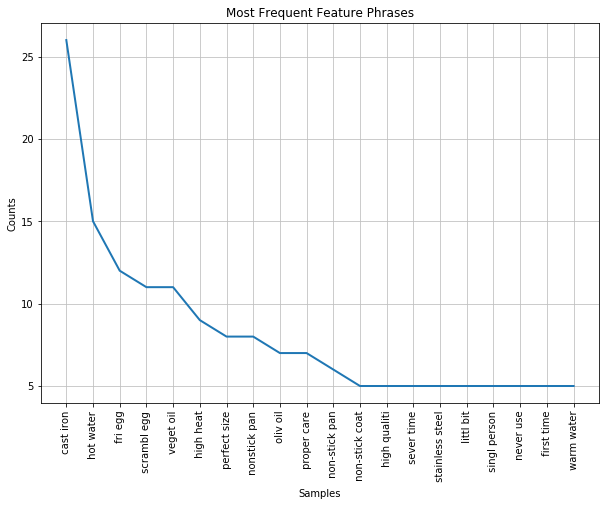

In [56]:
plt.figure(figsize=(10, 7))  # We want a bigger size plot
freqdist_neg.plot(20, title = "Most Frequent Feature Phrases", cumulative = False)

Unlemmatize and unstem using the dictionary created earlier

In [57]:
import inflect

In [58]:
print(extracted[:10])

[' non stick', ' unknown chemic', ' amaz skillet', ' alway bought', ' big-box store', ' whole batch', ' badli pre-season', ' realli rusti', ' soapi water', ' still wari']


In [59]:
p = inflect.engine()
def replacewords(mc):
    newmc=[]
    for a in tqdm(mc):
        newword="";found=False;
        for b in a[0].split():            
            for x in lem_word_mapping:
                #print(x)
                #print(b)
                if b==x:
                    found=True
                    sing=(lem_word_mapping[x] if p.singular_noun(lem_word_mapping[x])==False else p.singular_noun(lem_word_mapping[x]))
                    if newword=="":
                        newword = newword + sing
                    else:
                        newword = newword + " " +  sing
            if found==False:
                if newword=="":
                    newword = newword + b
                else:
                    newword = newword + " " +  b
                    #print(newword)
        newmc.append((newword,a[1]))
    return newmc

final = replacewords(most_common)
final_pos = replacewords(most_common_pos)
final_neg = replacewords(most_common_neg)

100%|██████████| 1109/1109 [00:00<00:00, 5258.64it/s]


In [60]:
print("Top Feature Phrases:")
print(final[0])
print(final[:50])
print("Top Positive Feature Phrases:")
print(final_pos[0])
print(final_pos[:50])
print("Top Negative Feature Phrases:")
print(final_neg[0])
print(final_neg[:50])

Top Feature Phrases:
('casting', 120)
[('casting', 120), ('hot water', 78), ('perfect size', 44), ('first time', 29), ('olive oiled', 29), ('non-stick pan', 28), ('vegetable oiled', 27), ('long time', 25), ('high heated', 23), ('fried egg', 22), ('well seasoning', 21), ('first casting', 21), ('non sticking', 18), ('high quality', 17), ('stainless steel', 17), ('inch skillet', 17), ('great pan', 16), ('grilled cheese', 16), ('little skillet', 16), ('proper careful', 16), ('scrambled egg', 16), ('never used', 15), ('great quality', 15), ('well made', 15), ('cast-iron skillet', 15), ('light coating', 15), ('goodnes quality', 14), ('little bit', 14), ('first used', 14), ('small amount', 14), ('thin layer', 14), ('properly seasoning', 14), ('nonstick pan', 14), ('warmed', 14), ('next time', 13), ('extra handle', 13), ('still hot', 13), ('many year', 13), ('great skillet', 13), ('stiff brush', 13), ('iron skillet', 12), ('several time', 12), ('non-stick coating', 11), ('great product', 11), 

We'll find out the opinions corresponding to the most common features.
Its a simple search in a bunch of lists/files at this point

In [77]:
def featuresInContext(item_arr, opinion_phrases, sentence_arr ):
    for item,support in tqdm(sorted(item_arr, key=lambda item_support: item_support[1], reverse=True)):
        count = 0
        print("------" + "Item > " + item[0] + "------")
        for phrase, freq in sorted(opinion_phrases, key = lambda phrase_freq: phrase_freq[1], reverse = True):
            pcount = 0
            if normalise(item[0]) in normalise(phrase):
                count+=1
                print("---" + "Phrase > " + phrase + "----")
                for l in sentence_arr:
                    if normalise(phrase) in normalise(l):
                        # print("Debug: " + l)
                        for b in zip(l.split(" ")[:-1], l.split(" ")[1:]):
                            #print(b[0]+" "+b[1])
                            if normalise(b[0])==normalise(item[0]):
                                print("---" + "examplex" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                            elif (normalise(b[0])+" "+normalise(b[1]))==normalise(item[0]):
                                print("---" + "exampley" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                        if pcount==4:
                            break                
            if count==4:
                break 
        
# sent_str = ""
# sent_str = sent_str.join(sent_fullreview)
# token_sentences = sent_tokenizer1.tokenize(sent_str)
# featuresInContext(items, final, sent_fullreview)

Modified to function without the item. Its assumed that the reviews are already constrained by the item in this case

In [74]:
def featuresInContextC(opinion_phrases, sentence_arr ):
    count = 0
    for phrase, freq in sorted(opinion_phrases, key = lambda phrase_freq: phrase_freq[1], reverse = True):
        pcount = 0
        count +=1
        print("---" + "Phrase > " + str(count) + " >>> " + phrase + "----")
        for l in sentence_arr:            
            if normalise(phrase) in normalise(l):
                pcount +=1
                print("---" + "example > " + str(pcount) + " >>> " + "----")
                print(l)
                
                if pcount == 4:
                    break
        if count == 4:
            break
              

In [80]:
print(len(items))
items_few = items[:2]
print(len(items_few))
print(items_few)

5
2
[(('cast',), 0.13639551192145863), (('skillet',), 0.18951612903225806)]


In [82]:
type(items)

list

In [83]:
type(items[0])

tuple

In [88]:
print(items)

[(('cast',), 0.13639551192145863), (('skillet',), 0.18951612903225806), (('pan',), 0.22808555399719496), (('iron',), 0.18127629733520337), (('iron', 'cast'), 0.13394109396914447)]


Sort by support

In [93]:
items.sort(key=lambda tup: tup[1], reverse=True) 

In [94]:
print(items)

[(('pan',), 0.22808555399719496), (('skillet',), 0.18951612903225806), (('iron',), 0.18127629733520337), (('cast',), 0.13639551192145863), (('iron', 'cast'), 0.13394109396914447)]


In [96]:
featuresInContext(items_few, final, sent_fullreview)

  0%|          | 0/2 [00:00<?, ?it/s]

------Item > skillet------
---Phrase > inch skillet----
---examplex----
Its not the easiest to clean, since you cant just throw it in the dish washer, but thats with any cast iron skillet.Bought this and the 8 inch skillet because I want to get away from teflon.
---examplex----
You can find that hereLodge 12 inch Skillet with Glass LidI received mine with no problems related to shipping.Got this for my boyfriend for christmas and he was so excited.
---examplex----
Cast iron is much better than stainless for fried eggs, and this spacious 15" pan would provide considerably more room for frying and could saute more without getting so crowded that the food gets steamed.I want it to work out, but I might have to downsize to the 13 inch skillet because I dont see a practical way to heat a pan this large evenly.The pan is heavy and very high quality.
---examplex----
Cooks three eggs every morning so perfectly your household will queue up to use it.I already have the 8 inch skillet and love it

 50%|█████     | 1/2 [00:00<00:00,  2.70it/s]

---examplex----
Every once in a while something sticks but a quick scrub with a scrubber sponge takes care of it.The surface is a little more pebbly than my 40-yr old, 12" cast-iron skillet (which has a mirror-like finish and nothing ever sticks to it) so eggs were a bit of a challenge at first, but after using it for 6 months they rarely stick; over time as I cook with it, it gets better and better.
---examplex----
This size about completes my set of cast-iron skillets and pans.
---examplex----
The pan is outstanding and cooks like a cast-iron skillet should...highly recommend this over paying a lot of money for a name brand skillet.What a wonderful pan!
---examplex----
I would certainly buy from this seller again and would certainly buy cast-iron skillets.....Ive been using this skillet for about five months now and I love it.
---Phrase > great skillet----
---examplex----
Did cornbread, turned the skillet upside down and the cornbread dropped right out by its ownself (as its said in 

100%|██████████| 2/2 [00:01<00:00,  2.21it/s]


In [76]:
featuresInContextC(final, sent_fullreview)

---Phrase > 1 >>> casting----
---example > 1 >>> ----
Just say no to chemical treatments on non stick pans, get yourself and your friends a few sizes of cast iron and have pans that you can pass down to your children, without all those unknown chemicals that are such a part of pans for the last few decades.This is an absolutely amazing skillet!!
---example > 2 >>> ----
This was horrible.I'm used to cast iron, for sure.
---example > 3 >>> ----
Been using good old American-made Lodge skillets for years, plus we regularly use a big cast iron wok imported from China.So, I'm giving only two stars because the pre-seasoning is a messy hassle.Now I've got to cook dinner.So far I am loving this skillet!
---example > 4 >>> ----
!If you are familiar with cast-iron, and are willing to give it the minimal care it requires, you'll love this.
---Phrase > 2 >>> hot water----
---example > 1 >>> ----
Then, I give it a good rinse in hot water and place the skillet into a hot oven until it is dry (quickly

In [ ]:
# featuresInContext(items_few, most_common_neg, sent_neg_review)

In [ ]:
# featuresInContext(items_few, most_common_pos, sent_pos_review)